Run the first cell, it will flag an error, then restart runtime and run all

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

In [ ]:
!pip install beautifulsoup4 requests pandas

# **Data Collection**

**Scrapping the news**

News data was collected by scraping 25 pages of stock-related articles from Business Insider. Using Python libraries such as requests and BeautifulSoup, headlines and their relative publication dates were extracted.

In [ ]:

import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

final = pd.DataFrame()

for j in range(1,26):
  webpage = requests.get(f'https://markets.businessinsider.com/news/infy-stock?p={j}&')
  soup = BeautifulSoup(webpage.content, 'lxml')
  company = soup.find_all('div', class_="latest-news__story")
  news = []
  date = []

  for i in company:
    try:
      news.append(i.find('a', class_="news-link").text.strip())
    except:
      news.append(np.nan)
    try:
      date.append(i.find(class_="latest-news__date").text.strip())
    except:
      date.append(np.nan)

  df = pd.DataFrame({'news': news, 'date': date})
  final = pd.concat([final,df], ignore_index=True)

from google.colab import files
from datetime import datetime, timedelta


def convert_to_absolute_date(relative_date):
  if relative_date is not None and isinstance(relative_date, str):
    if 'd' in relative_date:
      days_ago = int(relative_date.replace(',','').replace('d',''))
      absolute_date = datetime.now() - timedelta(days=days_ago)
      return absolute_date.strftime('%Y-%m-%d') # Format as yyyy-mm-dd
    elif 'h' in relative_date:
      hours_ago = int(relative_date.replace(',','').replace('h','')) # Extract the number of hours (remove 'h')
      absolute_date = datetime.now() - timedelta(hours=hours_ago) # Compute the absolute date
    return absolute_date.strftime('%Y-%m-%d') # Format as yyyy-mm-dd
    return relative_date # Return the original value if it's not a string or is None

final['date'] = final['date'].apply(convert_to_absolute_date)
print("\nDataFrame after converting dates:")
final.rename(columns={'date': 'Date'}, inplace=True)
print("\nDataFrame after renaming 'date' to 'Date':")



final.to_csv('news.csv', index=False)


#files.download('news.csv')


DataFrame after converting dates:

DataFrame after renaming 'date' to 'Date':


**Historical Stock Data Collection**

Concurrently, historical stock data for Infosys (INFY) was retrieved over a 12-year period with daily intervals using the yfinance library. This dual data collection ensured alignment between market events and corresponding news sentiment.

In [ ]:
import yfinance as yf
import pandas as pd
from google.colab import files

# Function to fetch stock data
def fetch_stock_data(ticker, period, interval='1d'):
    # Fetch historical market data
    try:
        # Initialize Ticker object
        stock = yf.Ticker(ticker)

        # Fetch historical market data
        data = stock.history(period=period, interval=interval)

        # Reset index to bring the date column into the DataFrame
        data.reset_index(inplace=True)

        # Convert the 'Date' column to datetime without time
        data['Date'] = pd.to_datetime(data['Date']).dt.date

        return data
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
ticker = 'INFY'
period = '12y'    # Fetch data for the last 10 years
interval = '1d'   # Daily data

# Fetch stock data for Apple Inc.
stock_data = fetch_stock_data(ticker, period=period, interval=interval)

# Convert to DataFrame and save to CSV
if stock_data is not None:
    stock_data_df = pd.DataFrame(stock_data)

    # Save DataFrame to a CSV file
    csv_file_path = f"{ticker}_stock_data.csv"
    stock_data_df.to_csv(csv_file_path, index=False)  # Save without index
    print(f"Stock data saved to {csv_file_path}")

    # Download the CSV file to your local machine
    #files.download(csv_file_path)
else:
    print("Failed to fetch stock data.")

Stock data saved to INFY_stock_data.csv


In [ ]:
!pip install vaderSentiment

# **Data Preprocessing**
For consistency, the relative dates (e.g., “2d” or “5h” ago) in the news dataset were converted into absolute dates (formatted as YYYY-MM-DD). The news and stock datasets were then merged on the date field, enabling the alignment of news sentiment with specific stock price movements. Additional preprocessing included standardizing numerical features and engineering target variables. One target variable was derived from sentiment analysis (positive sentiment is labeled as 1 if it exceeds negative sentiment, otherwise 0), and another represented the stock price increase by comparing the closing price of consecutive trading days.

In [ ]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np

In [ ]:
df1= pd.read_csv('news.csv')
df2= pd.read_csv('INFY_stock_data.csv')
merge = df1.merge(df2, how='inner', on='Date')

**Sentiment Analysis**

The VADER (Valence Aware Dictionary and sEntiment Reasoner) model was employed to perform sentiment analysis on the news headlines. For each headline, sentiment scores for negative, neutral, and positive sentiments were computed. These scores were then appended to the merged dataset, forming the basis for predicting the influence of news sentiment on stock price movements.


In [ ]:
def getSIA(text):
  sia = SentimentIntensityAnalyzer()
  sentiment = sia.polarity_scores(text)
  return sentiment

In [ ]:
neg=[]
neu=[]
pos=[]
SIA=0

for i in range(0,len(merge['news'])):
  SIA=getSIA(merge['news'][i])
  neg.append(SIA['neg'])
  neu.append(SIA['neu'])
  pos.append(SIA['pos'])

In [ ]:
merge['neg']=neg
merge['neu']=neu
merge['pos']=pos

In [ ]:
def get_sentiment_target(pos, neg):
    if pos > neg:
        return 1  # Positive
    #elif neg > pos and neg >
    elif neg > pos:
      return -1
    else:
        return 0  # Negative

In [ ]:
df = merge

In [ ]:
df['target'] = df.apply(lambda row: get_sentiment_target(row['pos'], row['neg']), axis=1)

In [ ]:
list_columns= ['Open','High','Low','Close','Volume','target']
df=df[list_columns]

In [ ]:
len(df)

1064

In [ ]:
df = df[df["target"] != 0]
df['target'] = df['target'].replace(-1, 0)

<ipython-input-16-3a10a380f797>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['target'].replace(-1, 0)


In [ ]:
import pandas as pd

# Assume 'df' is your DataFrame and 'target' is the class column
class_counts = df['target'].value_counts()
class_percentages = (class_counts / len(df)) * 100

print(class_percentages)

target
1    81.072027
0    18.927973
Name: count, dtype: float64


In [ ]:
x = df
x = np.array(x.drop(['target'], axis=1))
#Create the target dataset
y = np.array(df['target'])

# Model Evaluation with Resampling Techniques
The analysis compared the performance of multiple classifiers (Random Forest, XGBoost, CatBoost, and Logistic Regression) using different resampling techniques (Random Oversampling, SMOTE, ADASYN, Random Undersampling, and Tomek Links) on an imbalanced dataset. The evaluation metrics included ROC-AUC, precision, recall, and F1-score. The data was first split into training and test sets, standardized, and then each classifier was trained with and without resampling. Results were compiled into DataFrames and visualized using grouped bar charts to highlight the impact of resampling on model performance. The findings were saved as CSV files for further analysis, and the best-performing combinations were identified based on F1-scores and ROC-AUC values.


F1-Score Comparison:
Classifier            CatBoost  Logistic Regression  RandomForest   XGBoost
Resampler                                                                  
None                  0.746300             0.703913      0.758947  0.779931
Tomek Links           0.746679             0.703913      0.775641  0.773479
Random Oversampling   0.757023             0.693257      0.753551  0.762429
SMOTE                 0.732654             0.701191      0.737651  0.758333
ADASYN                0.727244             0.693750      0.699077  0.732854
Random Undersampling  0.715963             0.701191      0.731316  0.709062


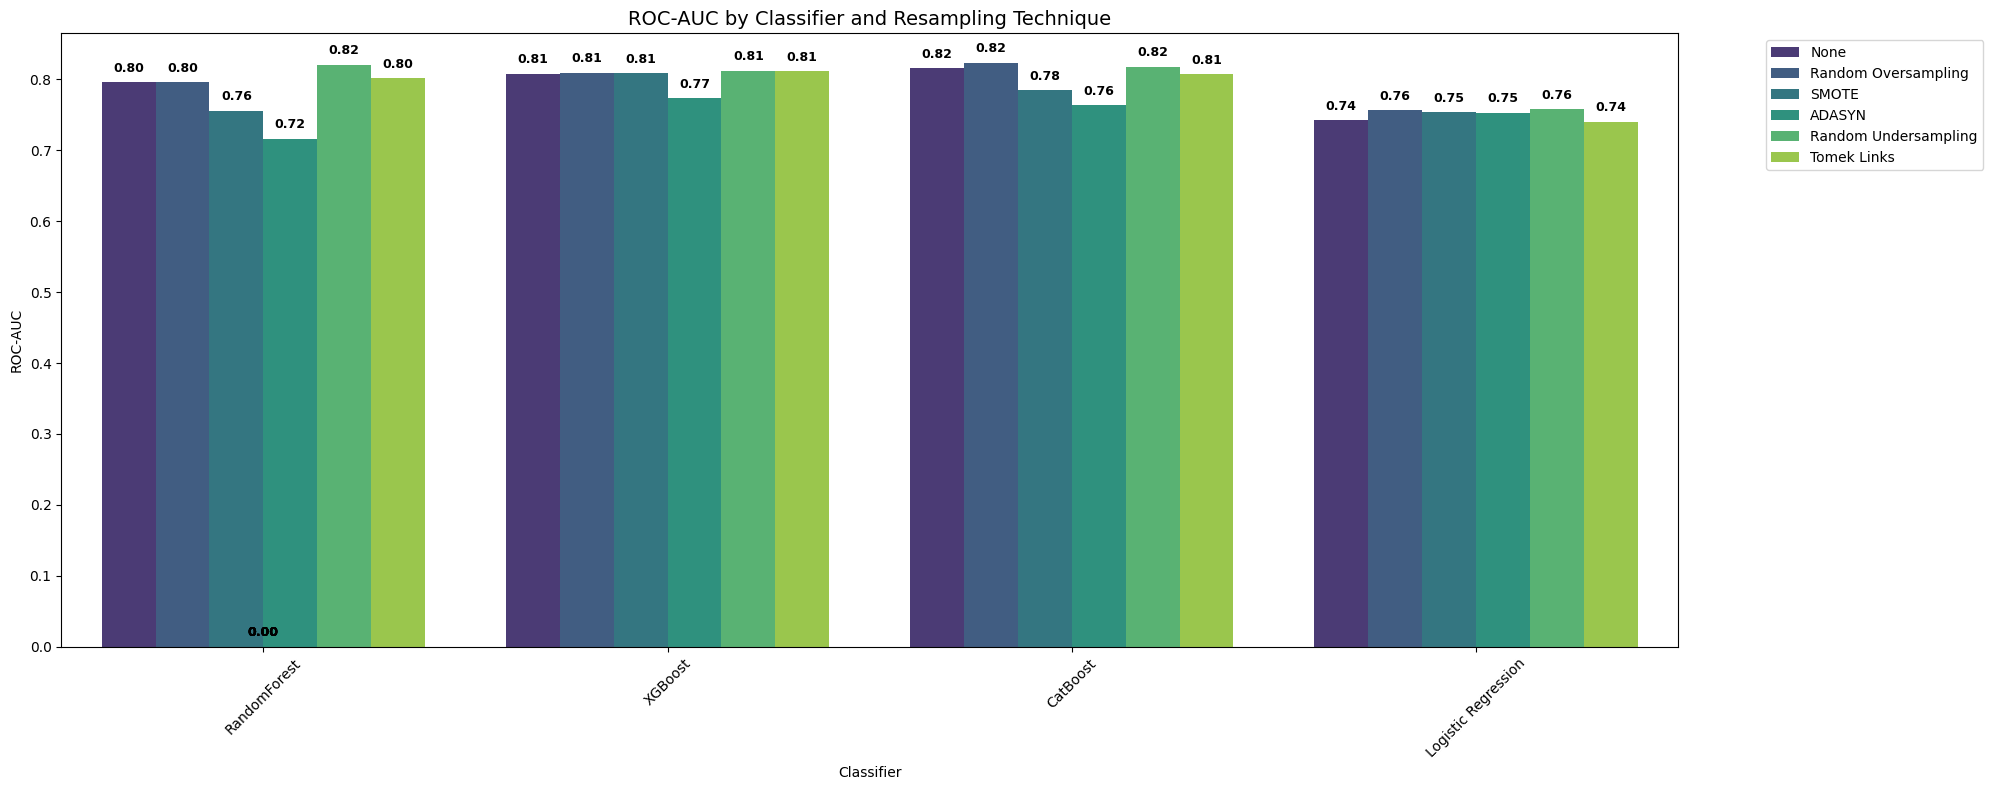

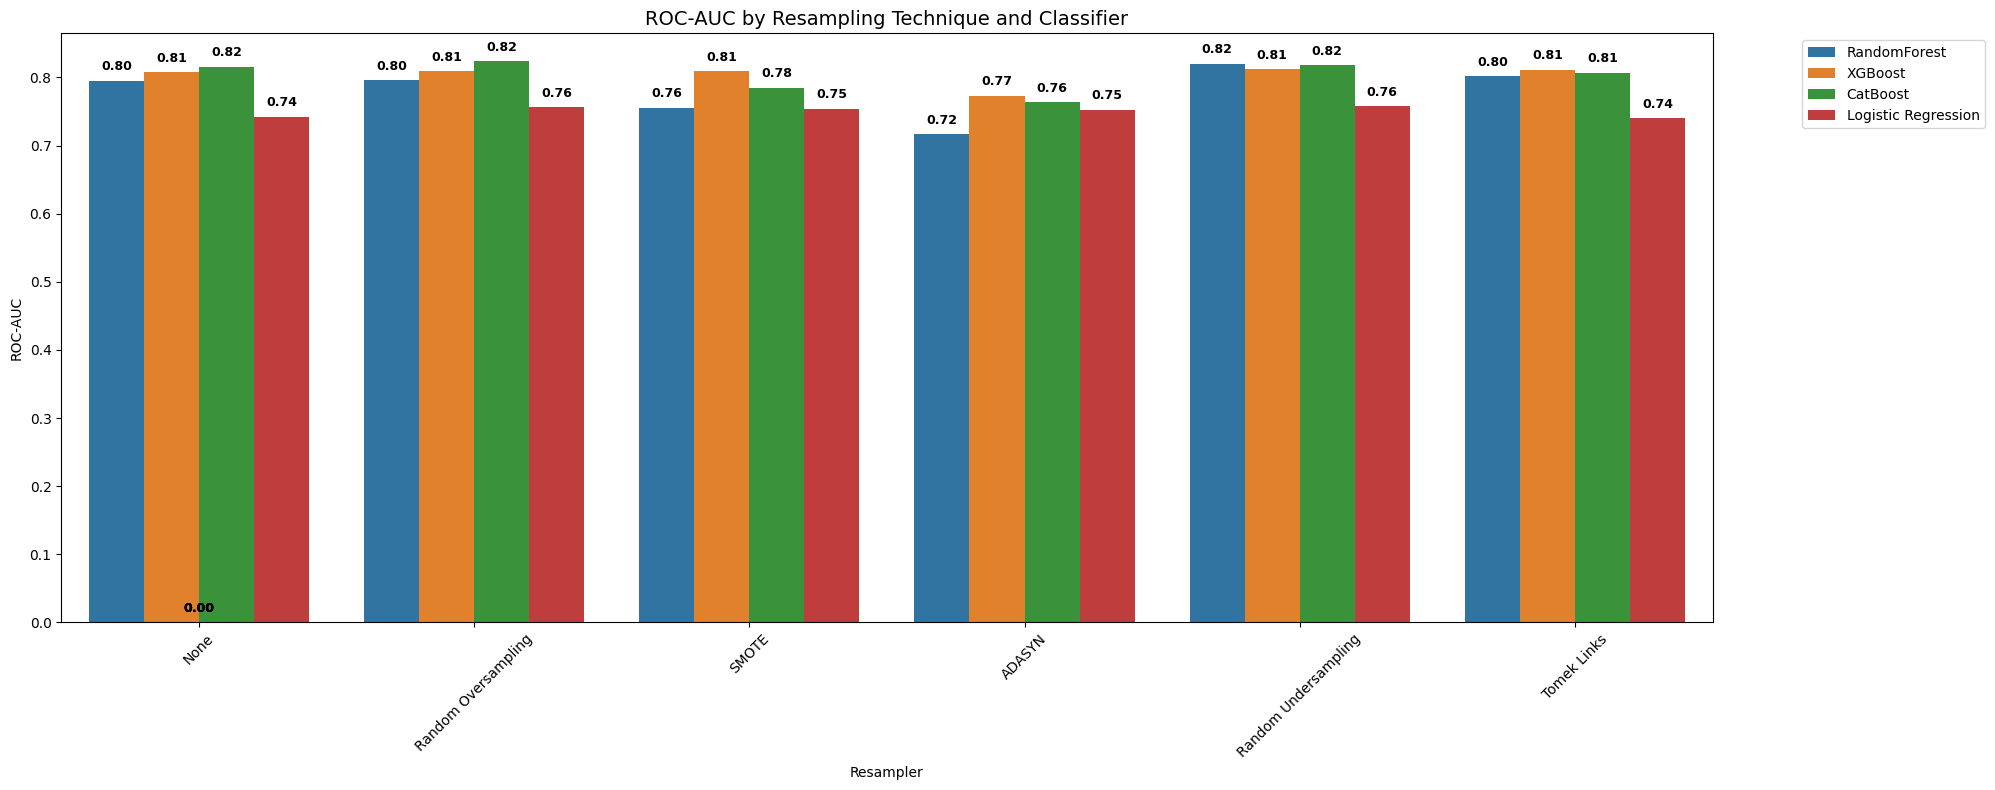

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42 ) # stratify=y,

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

resamplers = {
    "None": None,
    "Random Oversampling": RandomOverSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
    "Random Undersampling": RandomUnderSampler(random_state=42),
    "Tomek Links": TomekLinks(),
}

# Define classifiers (enable probability for ROC-AUC)
classifiers = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
}

# Evaluate all combinations
results_roc = []
results = []
for clf_name, clf in classifiers.items():
    for resampler_name, resampler in resamplers.items():
        # Create pipeline
        if resampler is None:
            pipeline = clf
        else:
            pipeline = Pipeline([('resampler', resampler), ('classifier', clf)])

        # Train and predict probabilities (for ROC-AUC)
        pipeline.fit(X_train, y_train)
        y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for class 1
        y_pred = pipeline.predict(X_test)
        roc_auc = roc_auc_score(y_test, y_proba)

        # Store results
        results_roc.append({
            'Classifier': clf_name,
            'Resampler': resampler_name,
            'ROC-AUC': roc_auc,
        })

        report = classification_report(y_test, y_pred, output_dict=True)
        results.append({
            'Classifier': clf_name,
            'Resampler': resampler_name,
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1-Score': report['weighted avg']['f1-score'],
        })

results_roc_df = pd.DataFrame(results_roc)
results_df = pd.DataFrame(results)

results_df.to_csv('resampling_model_comparison.csv', index=False)
results_roc_df.to_csv('roc_auc_results.csv', index=False)

pivot_results = results_df.pivot_table(index='Resampler', columns='Classifier', values='F1-Score', aggfunc='first')
print("\nF1-Score Comparison:")
print(pivot_results.sort_values(by='XGBoost', ascending=False))  # Sort by XGBoost performance (change as needed)


# 1. Grouped Bar Chart (Models grouped by Resampling Technique)
plt.figure(figsize=(20, 8))
ax = sns.barplot(data=results_roc_df, x='Classifier', y='ROC-AUC', hue='Resampler', palette='viridis')
plt.title('ROC-AUC by Classifier and Resampling Technique', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# Add value labels on each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=9,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

# 2. Alternative View (Resamplers grouped by Model)
plt.figure(figsize=(20, 8))
ax = sns.barplot(data=results_roc_df, x='Resampler', y='ROC-AUC', hue='Classifier', palette='tab10')
plt.title('ROC-AUC by Resampling Technique and Classifier', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# Add value labels on each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=9,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

# **Hyperparameter Tuning and Final Model Evaluation**
After identifying the best resampling technique for each classifier (Random Forest, XGBoost, CatBoost, and Logistic Regression) based on ROC-AUC scores, hyperparameter tuning was performed using RandomizedSearchCV with a predefined parameter grid for each model. The best-performing configurations were evaluated on the test set, recording ROC-AUC and F1-scores. The results were compiled into a DataFrame and visualized in a bar chart, highlighting the final model performances along with their optimal resampling methods and tuned hyperparameters. This process ensured that each model was optimized for the highest predictive performance on the imbalanced dataset.


Best Resampling Technique for Each Model:
RandomForest: Random Undersampling (ROC-AUC: 0.820)
XGBoost: Random Undersampling (ROC-AUC: 0.812)
CatBoost: Random Oversampling (ROC-AUC: 0.824)
Logistic Regression: Random Undersampling (ROC-AUC: 0.757)

Tuning RandomForest with Random Undersampling...
Best params: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 20}
Best CV ROC-AUC: 0.738

Tuning XGBoost with Random Undersampling...
Best params: {'classifier__subsample': 0.8, 'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01, 'classifier__colsample_bytree': 0.8}
Best CV ROC-AUC: 0.741

Tuning CatBoost with Random Oversampling...
Best params: {'classifier__learning_rate': 0.01, 'classifier__l2_leaf_reg': 3, 'classifier__iterations': 200, 'classifier__depth': 4}
Best CV ROC-AUC: 0.764

Tuning Logistic Regression with Random Undersampling...
Best params: {'classifier__

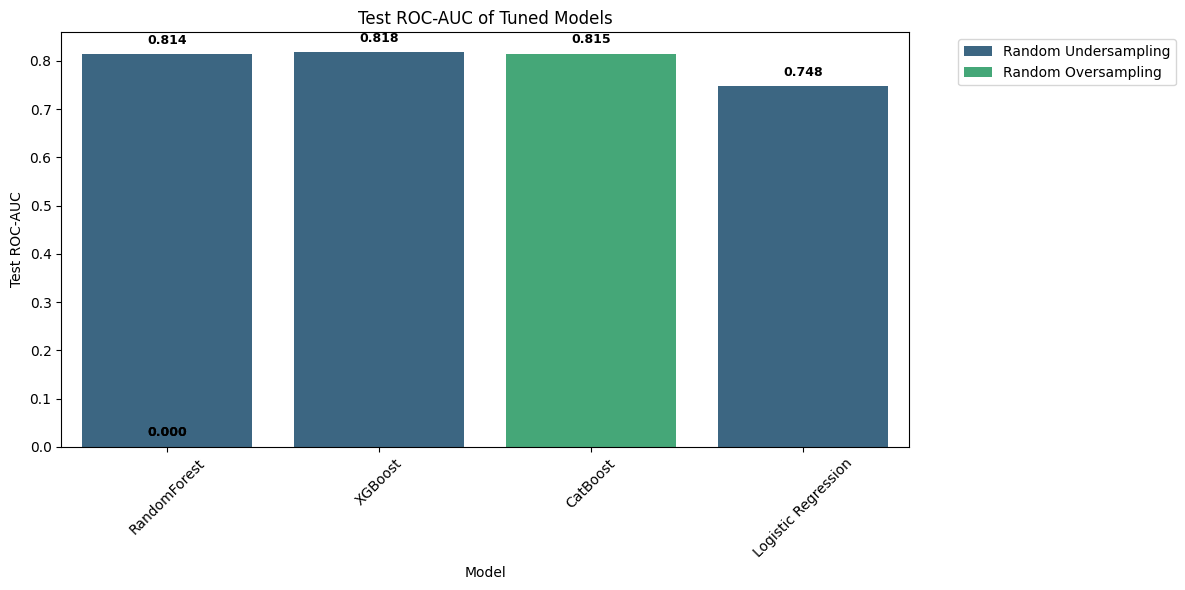

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# 1. Identify best resampling technique for each model
best_combinations = {}
for model in results_roc_df['Classifier'].unique():
    model_df = results_roc_df[results_roc_df['Classifier'] == model]
    best_resampler = model_df.loc[model_df['ROC-AUC'].idxmax(), 'Resampler']
    best_combinations[model] = best_resampler

print("\nBest Resampling Technique for Each Model:")
for model, resampler in best_combinations.items():
    print(f"{model}: {resampler} (ROC-AUC: {results_roc_df[(results_roc_df['Classifier'] == model) & (results_roc_df['Resampler'] == resampler)]['ROC-AUC'].values[0]:.3f})")

# 2. Hyperparameter tuning for each best combination
param_grids = {
    "RandomForest": {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "XGBoost": {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    },
    "CatBoost": {
        'iterations': [100, 200, 500],
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.2],
        'l2_leaf_reg': [1, 3, 5]
    },
    "Logistic Regression": {
        'C': np.logspace(-3, 3, 7),
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
}

# 3. Perform tuning for each best combination
tuned_models = {}
for model_name, resampler in best_combinations.items():
    print(f"\nTuning {model_name} with {resampler}...")

    # Get classifier and params
    clf = classifiers[model_name]
    param_grid = param_grids[model_name]

    # Create pipeline
    if resampler == "None":
        pipeline = clf
    else:
        pipeline = Pipeline([
            ('resampler', resamplers[resampler]),
            ('classifier', clf)
        ])

    # Adjust param grid for pipeline
    if resampler != "None":
        param_grid = {f'classifier__{k}': v for k, v in param_grid.items()}

    # RandomizedSearchCV
    search = RandomizedSearchCV(
        pipeline,
        param_grid,
        n_iter=20,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)

    # Store best model
    tuned_models[model_name] = {
        'model': search.best_estimator_,
        'params': search.best_params_,
        'score': search.best_score_
    }

    print(f"Best params: {search.best_params_}")
    print(f"Best CV ROC-AUC: {search.best_score_:.3f}")

# 4. Evaluate tuned models on test set
print("\nFinal Evaluation on Test Set:")
final_results = []
for model_name, model_info in tuned_models.items():
    best_model = model_info['model']
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    final_results.append({
        'Model': model_name,
        'Resampler': best_combinations[model_name],
        'Test ROC-AUC': roc_auc_score(y_test, y_proba),
        'Test F1-Score': classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score'],
        'Best Parameters': model_info['params']
    })

final_results_df = pd.DataFrame(final_results)
print("\n", final_results_df.sort_values('Test ROC-AUC', ascending=False))

# 5. Visualize final comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=final_results_df, x='Model', y='Test ROC-AUC', hue='Resampler', palette='viridis')
plt.title('Test ROC-AUC of Tuned Models')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# Add value labels
for p in plt.gca().patches:
    plt.gca().annotate(
        f"{p.get_height():.3f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=9,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

# **Best Model Selection and Comprehensive Evaluation**
The best-performing model was selected based on the highest test ROC-AUC score, followed by a detailed evaluation that included accuracy, precision, recall, F1-score, ROC-AUC, and PR-AUC metrics. A confusion matrix and performance curves (ROC and precision-recall) were generated to assess classification performance visually. Feature importance analysis was conducted (where applicable) to identify the most influential predictors, and the final model was saved as a .pkl file for future deployment. This comprehensive analysis ensured a robust understanding of the model's predictive capabilities and decision-making behavior on the imbalanced dataset.


🌟 BEST OVERALL MODEL: XGBoost with Random Undersampling
🏆 Test ROC-AUC: 0.8182
🔍 Best Parameters: {'classifier__subsample': 0.8, 'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01, 'classifier__colsample_bytree': 0.8}


📊 COMPREHENSIVE EVALUATION METRICS:
Accuracy: 0.6750
Precision: 0.7719
Recall: 0.6750
F1-Score: 0.7006
ROC-AUC: 0.8182
PR-AUC: 0.9424

📈 CONFUSION MATRIX:
[[19  8]
 [31 62]]


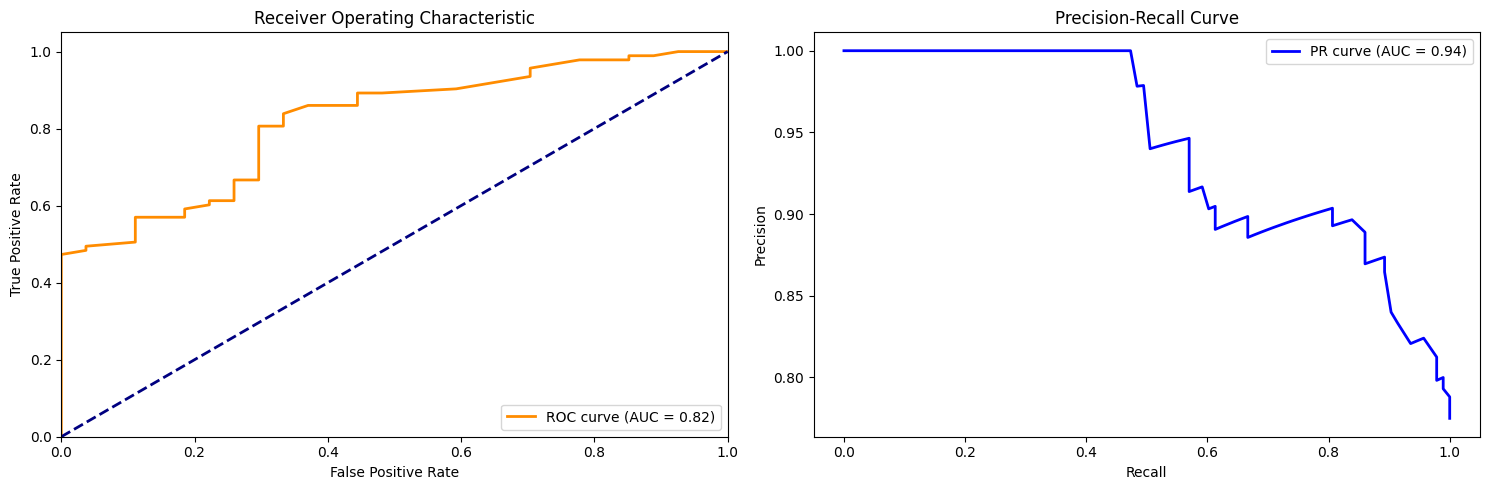


💾 Best model saved as 'best_model.pkl'


In [ ]:
# After the previous tuning code, add this:

# 1. Select the best overall model based on Test ROC-AUC
best_model_info = final_results_df.loc[final_results_df['Test ROC-AUC'].idxmax()]
best_model = tuned_models[best_model_info['Model']]['model']

print("\n" + "="*80)
print(f"🌟 BEST OVERALL MODEL: {best_model_info['Model']} with {best_model_info['Resampler']}")
print(f"🏆 Test ROC-AUC: {best_model_info['Test ROC-AUC']:.4f}")
print(f"🔍 Best Parameters: {best_model_info['Best Parameters']}")
print("="*80 + "\n")

# 2. Generate comprehensive evaluation report
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc, precision_recall_curve

def evaluate_model(model, X_test, y_test):
    # Generate predictions and probabilities
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_proba)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # ROC Curve data
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve data
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall_curve, precision_curve)

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc,
        'Confusion Matrix': cm,
        'ROC Curve': (fpr, tpr),
        'PR Curve': (precision_curve, recall_curve)
    }

# Evaluate best model
metrics = evaluate_model(best_model, X_test, y_test)

# 3. Print comprehensive report
print("\n📊 COMPREHENSIVE EVALUATION METRICS:")
print(f"Accuracy: {metrics['Accuracy']:.4f}")
print(f"Precision: {metrics['Precision']:.4f}")
print(f"Recall: {metrics['Recall']:.4f}")
print(f"F1-Score: {metrics['F1-Score']:.4f}")
print(f"ROC-AUC: {metrics['ROC-AUC']:.4f}")
print(f"PR-AUC: {metrics['PR-AUC']:.4f}\n")

print("📈 CONFUSION MATRIX:")
print(metrics['Confusion Matrix'])

# 4. Plot performance curves
plt.figure(figsize=(15, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(metrics['ROC Curve'][0], metrics['ROC Curve'][1], color='darkorange', lw=2,
         label=f'ROC curve (AUC = {metrics["ROC-AUC"]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(metrics['PR Curve'][1], metrics['PR Curve'][0], color='blue', lw=2,
         label=f'PR curve (AUC = {metrics["PR-AUC"]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

# 5. Feature Importance (if available)
try:
    if hasattr(best_model, 'feature_importances_'):
        # Handle pipeline
        if hasattr(best_model, 'named_steps'):
            importances = best_model.named_steps['classifier'].feature_importances_
        else:
            importances = best_model.feature_importances_

        feature_importance = pd.DataFrame({
            'Feature': x.columns,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature')
        plt.title('Top 10 Important Features')
        plt.tight_layout()
        plt.show()

        print("\n🔝 TOP 10 IMPORTANT FEATURES:")
        print(feature_importance.head(10))
except Exception as e:
    print(f"\n⚠️ Could not extract feature importance: {str(e)}")

# 6. Save the best model
import joblib
joblib.dump(best_model, 'best_model.pkl')
print("\n💾 Best model saved as 'best_model.pkl'")

# **Comparative ROC Analysis of Optimized Models**
The analysis generated a composite ROC curve plot comparing the performance of all optimized models (Random Forest, XGBoost, CatBoost, and Logistic Regression) after hyperparameter tuning. Each model's curve was plotted along with its corresponding AUC score, demonstrating their ability to distinguish between classes at different classification thresholds. The visualization included a diagonal reference line representing random guessing, enabling clear performance comparison across models. This comparative assessment helps identify which algorithm maintains the best trade-off between true positive and false positive rates across all probability thresholds.

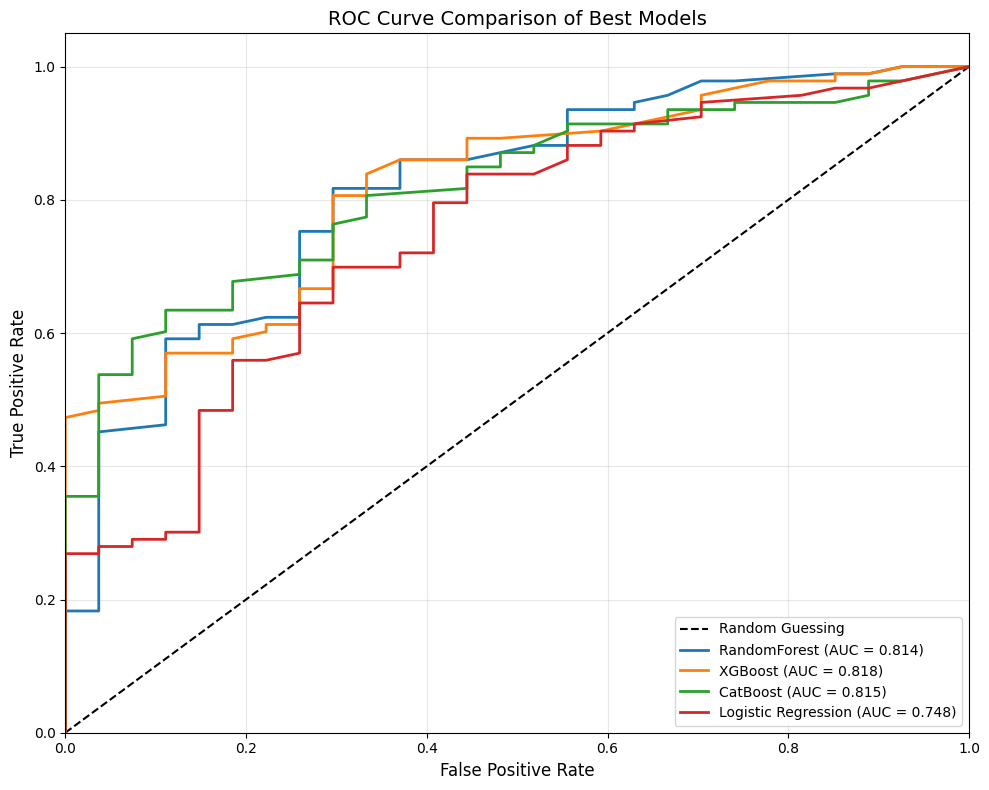

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

# Dictionary to store best models (replace with your actual tuned models)
best_models = {
    'RandomForest': tuned_models['RandomForest']['model'],
    'XGBoost': tuned_models['XGBoost']['model'],
    'CatBoost': tuned_models['CatBoost']['model'],
    'Logistic Regression': tuned_models['Logistic Regression']['model']
}

# Plot ROC for each best model
for model_name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr,
             label=f'{model_name} (AUC = {roc_auc:.3f})',
             linewidth=2)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison of Best Models', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

# **Comprehensive Model Benchmarking and Evaluation**
The analysis conducted a thorough performance comparison of all optimized models (including Random Forest, XGBoost, CatBoost, and Logistic Regression) through multiple evaluation metrics and visualizations. Key metrics (accuracy, precision, recall, F1-score, and ROC-AUC) were calculated and displayed in a ranked table, while detailed classification reports provided class-specific performance insights. The evaluation included visual comparisons of confusion matrices and ROC curves for all models, along with feature importance analysis for tree-based algorithms. This comprehensive benchmarking approach enabled direct comparison of each model's predictive performance, decision patterns, and important features, providing a complete picture of their relative strengths and weaknesses on the test dataset.

🏆 Model Performance Comparison:


,Model,Resampler,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Best Parameters
1,XGBoost,Random Undersampling,0.675000,0.771929,0.675000,0.700610,0.818200,"{'classifier__subsample': 0.8, 'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01, 'classifier__colsample_bytree': 0.8}"
2,CatBoost,Random Oversampling,0.708333,0.813207,0.708333,0.731838,0.815213,"{'classifier__learning_rate': 0.01, 'classifier__l2_leaf_reg': 3, 'classifier__iterations': 200, 'classifier__depth': 4}"
0,RandomForest,Random Undersampling,0.691667,0.787500,0.691667,0.715963,0.814018,"{'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 20}"
3,Logistic Regression,Random Undersampling,0.666667,0.768968,0.666667,0.693257,0.747909,"{'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__C': 100.0}"



📊 Detailed Classification Reports:

=== RandomForest ===
              precision    recall  f1-score   support

           0      0.400     0.741     0.519        27
           1      0.900     0.677     0.773        93

    accuracy                          0.692       120
   macro avg      0.650     0.709     0.646       120
weighted avg      0.787     0.692     0.716       120


=== XGBoost ===
              precision    recall  f1-score   support

           0      0.380     0.704     0.494        27
           1      0.886     0.667     0.761        93

    accuracy                          0.675       120
   macro avg      0.633     0.685     0.627       120
weighted avg      0.772     0.675     0.701       120


=== CatBoost ===
              precision    recall  f1-score   support

           0      0.423     0.815     0.557        27
           1      0.926     0.677     0.783        93

    accuracy                          0.708       120
   macro avg      0.675     0.746  

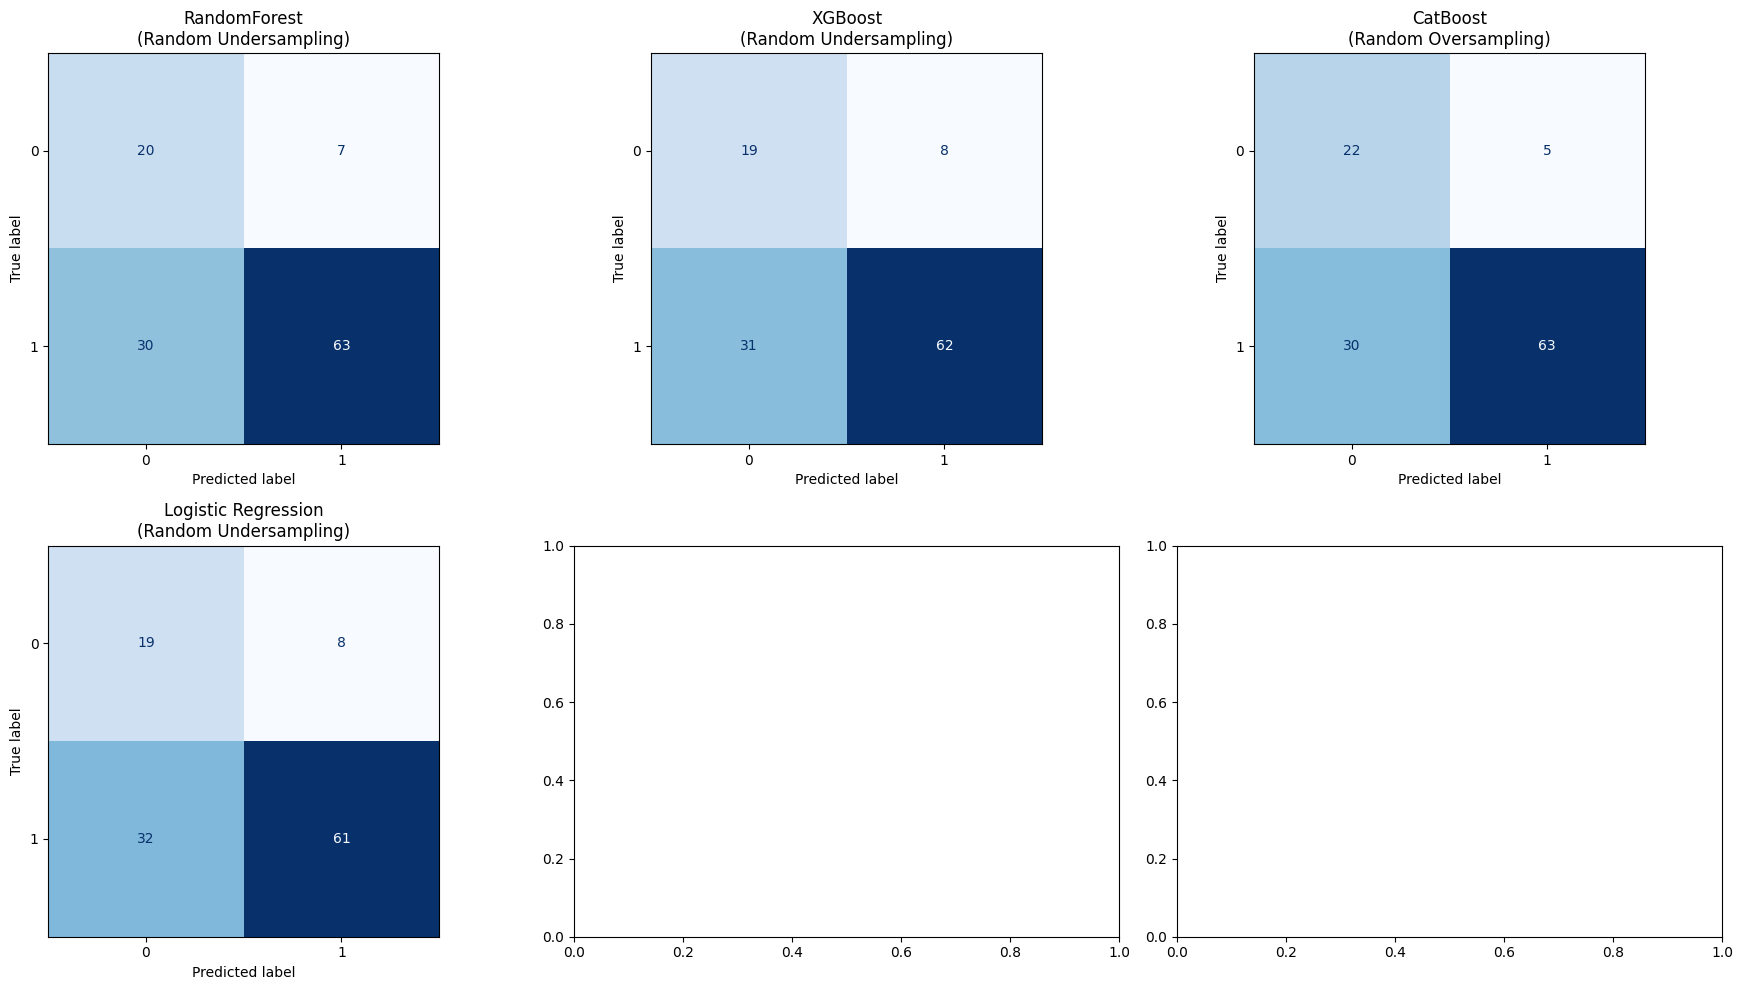

<Figure size 1000x800 with 0 Axes>

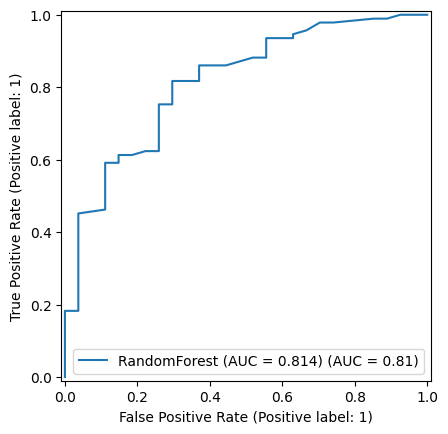

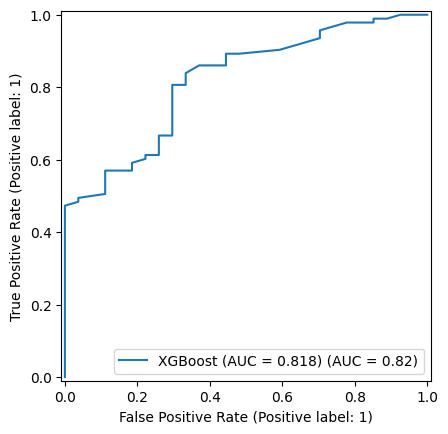

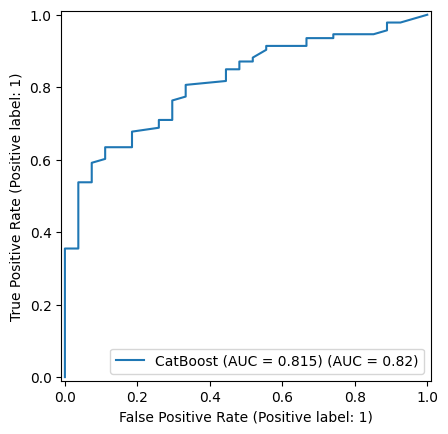

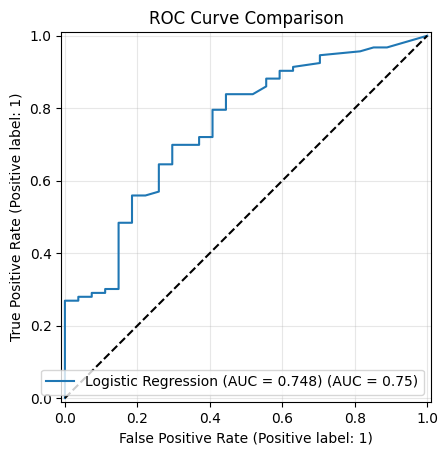

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report, RocCurveDisplay, ConfusionMatrixDisplay)

# 1. Initialize results storage
metrics_list = []

# 2. Evaluate each best model
for model_name, model_info in tuned_models.items():
    model = model_info['model']
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Resampler': best_combinations[model_name],
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted'),
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'Best Parameters': str(model_info['params'])
    }
    metrics_list.append(metrics)

# 3. Create comparison dataframe
results_df = pd.DataFrame(metrics_list)
results_df = results_df.sort_values('ROC-AUC', ascending=False)
print("🏆 Model Performance Comparison:")
display(results_df.style.background_gradient(cmap='Blues', subset=['Accuracy', 'F1-Score', 'ROC-AUC']))

# 4. Detailed classification reports
print("\n📊 Detailed Classification Reports:")
for model_name, model_info in tuned_models.items():
    print(f"\n=== {model_name} ===")
    y_pred = model_info['model'].predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))

# 5. Confusion Matrix Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for (model_name, model_info), ax in zip(tuned_models.items(), axes.flatten()):
    if model_name not in tuned_models:  # Handle case with <6 models
        ax.axis('off')
        continue

    ConfusionMatrixDisplay.from_estimator(
        model_info['model'], X_test, y_test,
        ax=ax, cmap='Blues', colorbar=False
    )
    ax.set_title(f"{model_name}\n({best_combinations[model_name]})")
plt.tight_layout()
plt.show()

# 6. ROC Curve Comparison
plt.figure(figsize=(10, 8))
for model_name, model_info in tuned_models.items():
    RocCurveDisplay.from_estimator(
        model_info['model'], X_test, y_test,
        name=f"{model_name} (AUC = {results_df[results_df['Model']==model_name]['ROC-AUC'].values[0]:.3f})"
    )
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.grid(alpha=0.3)
plt.show()

# 7. Feature Importance (for tree-based models)
try:
    tree_models = [m for m in tuned_models.items()
                  if hasattr(m[1]['model'], 'feature_importances_')]
    if tree_models:
        fig, axes = plt.subplots(len(tree_models), 1, figsize=(10, 4*len(tree_models)))
        for (model_name, model_info), ax in zip(tree_models, axes.flatten()):
            # Handle pipeline vs direct model
            if hasattr(model_info['model'], 'named_steps'):
                importances = model_info['model'].named_steps['classifier'].feature_importances_
            else:
                importances = model_info['model'].feature_importances_

            pd.Series(importances, index=x.columns).nlargest(10).plot.barh(ax=ax)
            ax.set_title(f"{model_name} - Top 10 Features")
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"Feature importance visualization skipped: {str(e)}")


=== None ===

=== SMOTE ===

=== RandomOver ===

=== RandomUnder ===

=== TomekLinks ===


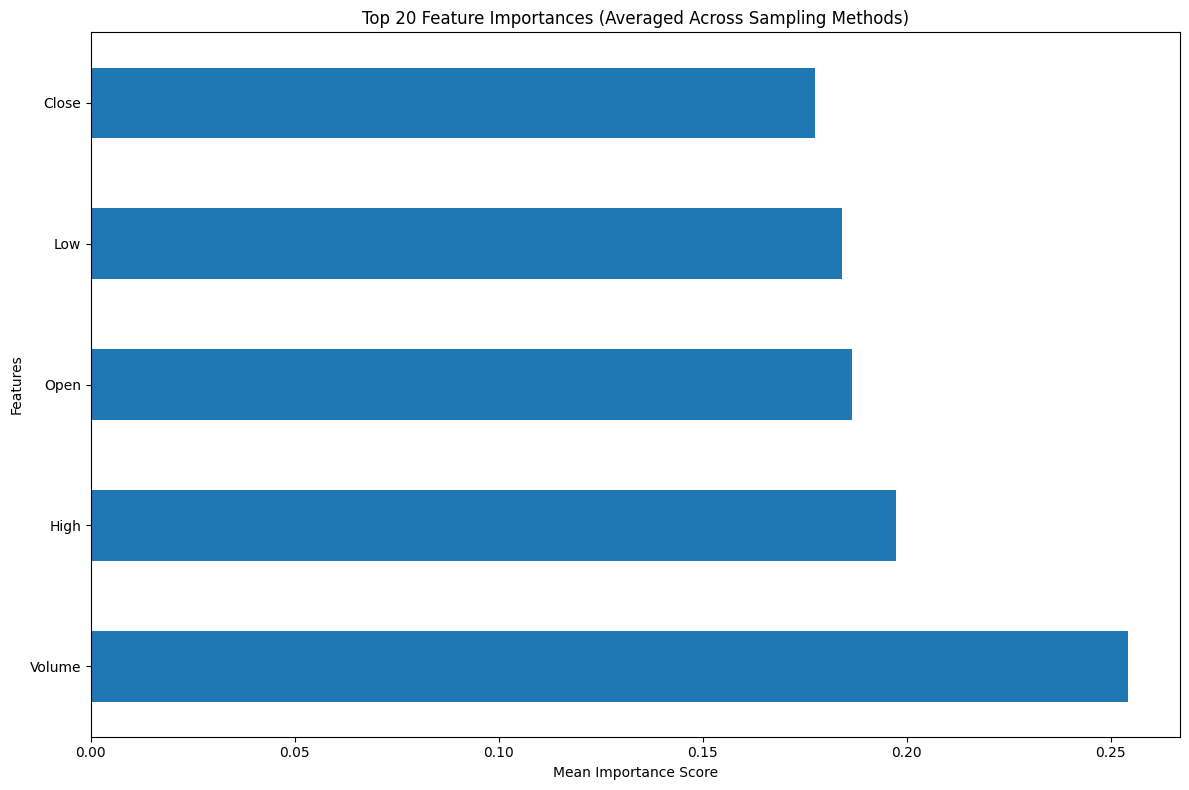

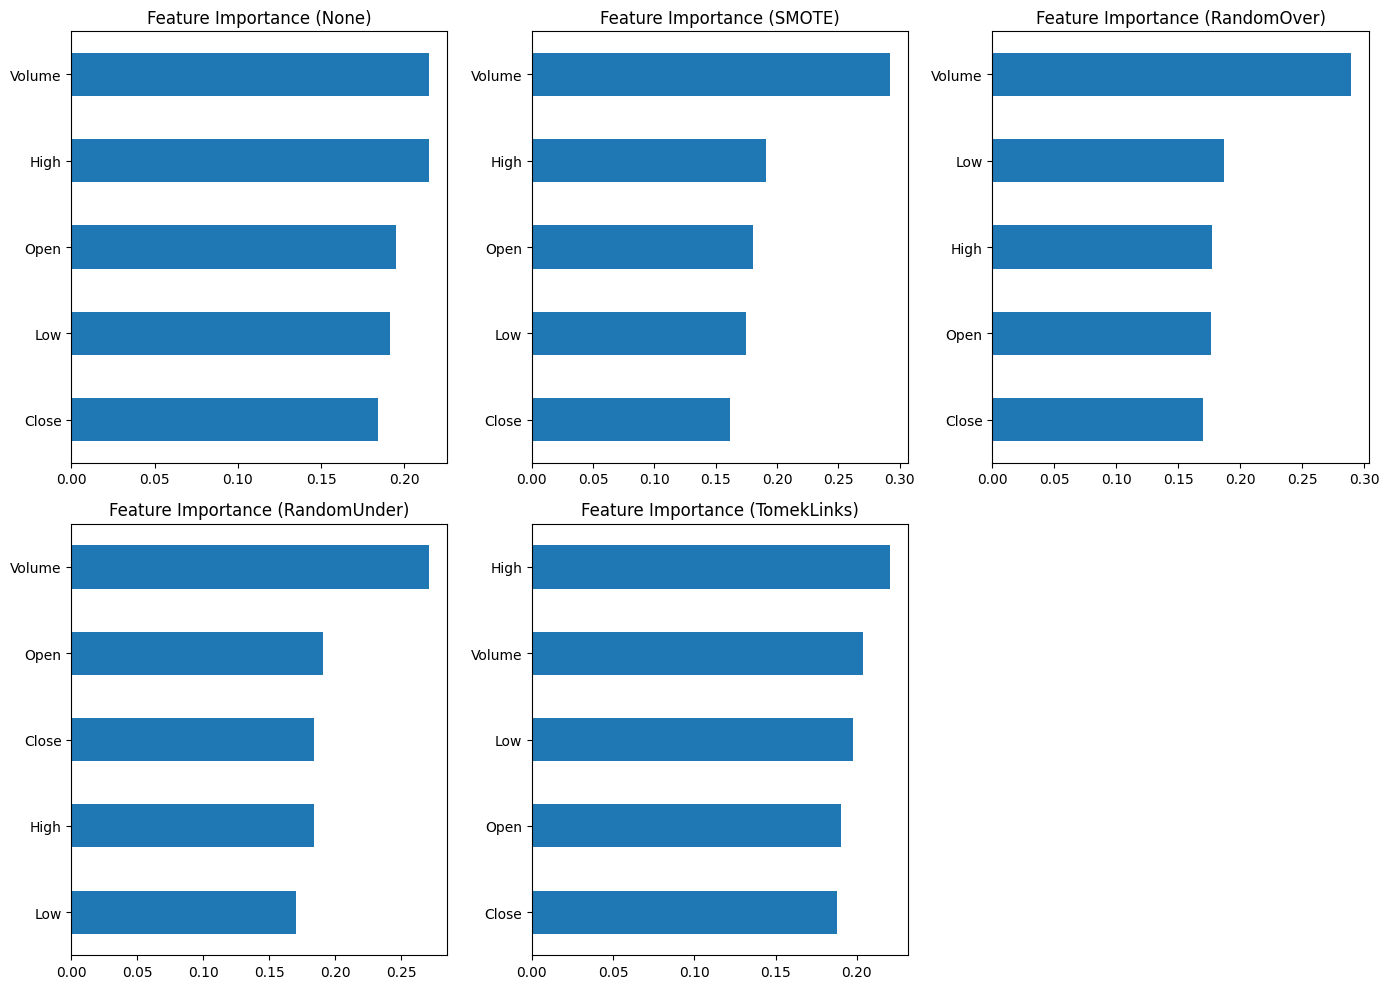


Top 10 Most Important Features:
            None     SMOTE  RandomOver  RandomUnder  TomekLinks  \
Volume  0.215037  0.292233    0.289257     0.271213    0.203797   
High    0.214800  0.191155    0.177164     0.183691    0.220485   
Open    0.194640  0.180276    0.176280     0.190933    0.190371   
Low     0.191334  0.174326    0.187244     0.170044    0.197775   
Close   0.184189  0.162009    0.170055     0.184118    0.187572   

        Mean_Importance  
Volume         0.254307  
High           0.197459  
Open           0.186500  
Low            0.184145  
Close          0.177589  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

# 1. Prepare Data
X = df.drop('target', axis=1)
y = df['target']
feature_names = X.columns.tolist()

# 2. Define Sampling Techniques
samplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=42),
    'RandomOver': RandomOverSampler(random_state=42),
    'RandomUnder': RandomUnderSampler(random_state=42),
    'TomekLinks': TomekLinks()
}

# 3. Train Random Forest with Feature Importance Extraction
results = {}

for sampler_name, sampler in samplers.items():
    print(f"\n=== {sampler_name} ===")

    # Create pipeline
    if sampler:
        pipeline = Pipeline([
            ('sampler', sampler),
            ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
        ])
    else:
        pipeline = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train model
    pipeline.fit(X, y)

    # Extract feature importances
    if sampler:
        importances = pipeline.named_steps['classifier'].feature_importances_
    else:
        importances = pipeline.feature_importances_

    # Store results
    results[sampler_name] = importances

# 4. Create Feature Importance DataFrame
importance_df = pd.DataFrame(results, index=feature_names)
importance_df['Mean_Importance'] = importance_df.mean(axis=1)
importance_df = importance_df.sort_values('Mean_Importance', ascending=False)

# 5. Visualize Top Features
plt.figure(figsize=(12, 8))
importance_df.head(20)['Mean_Importance'].plot(kind='barh')
plt.title('Top 20 Feature Importances (Averaged Across Sampling Methods)')
plt.xlabel('Mean Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# 6. Detailed Comparison Plot
plt.figure(figsize=(14, 10))
for i, sampler in enumerate(samplers.keys(), 1):
    plt.subplot(2, 3, i)
    pd.Series(results[sampler], index=feature_names).sort_values().tail(15).plot(kind='barh')
    plt.title(f'Feature Importance ({sampler})')
plt.tight_layout()
plt.show()

# 7. Export Results
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Save to CSV
importance_df.to_csv('feature_importances.csv')

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Prepare data
x = df.drop(['target'], axis=1).values
y = df['target'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Define sampling techniques to evaluate
sampling_techniques = {
    'None': None,
    'RandomOver': RandomOverSampler(random_state=42),
    'RandomUnder': RandomUnderSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42),
    'TomekLinks': TomekLinks(),
    'SMOTETomek': SMOTETomek(random_state=42)
}

# Neural Network Architecture
class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Training function
def train_model(X_train, y_train, X_val, y_val, sampling_method=None):
    # Apply sampling if specified
    if sampling_method:
        X_res, y_res = sampling_method.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train

    # Convert to tensors
    X_tensor = torch.FloatTensor(X_res)
    y_tensor = torch.FloatTensor(y_res).view(-1, 1)

    # Handle class imbalance via weighted sampler if no sampling technique
    if sampling_method is None:
        class_counts = np.bincount(y_res)
        class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
        sample_weights = class_weights[y_res]
        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )
        train_loader = DataLoader(
            TensorDataset(X_tensor, y_tensor),
            batch_size=64,
            sampler=sampler
        )
    else:
        train_loader = DataLoader(
            TensorDataset(X_tensor, y_tensor),
            batch_size=64,
            shuffle=True
        )

    # Validation data
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val).view(-1, 1)
    val_loader = DataLoader(
        TensorDataset(X_val_tensor, y_val_tensor),
        batch_size=64
    )

    # Initialize model
    model = BinaryClassifier(input_size=X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(50):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.FloatTensor(X_test)).numpy()
        y_pred_class = (y_pred > 0.5).astype(int)

        print(f"\nSampling: {sampling_method.__class__.__name__ if sampling_method else 'None'}")
        print(classification_report(y_test, y_pred_class))
        print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.4f}")

    return model

# Split validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Evaluate all sampling techniques
for name, sampler in sampling_techniques.items():
    print(f"\n{'='*40}\nEvaluating: {name}\n{'='*40}")
    model = train_model(X_train, y_train, X_val, y_val, sampler)


Evaluating: None

Sampling: None
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.78      1.00      0.87        93

    accuracy                           0.78       120
   macro avg       0.39      0.50      0.44       120
weighted avg       0.60      0.78      0.68       120

ROC AUC: 0.5000

Evaluating: RandomOver

Sampling: RandomOverSampler
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.78      1.00      0.87        93

    accuracy                           0.78       120
   macro avg       0.39      0.50      0.44       120
weighted avg       0.60      0.78      0.68       120

ROC AUC: 0.5000

Evaluating: RandomUnder

Sampling: RandomUnderSampler
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.78      1.00      0.87        93

    accu